In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import warnings 
warnings.filterwarnings('ignore')

/home/w_lander/anaconda3/envs/dowgrade/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Датасет (Сентимент-анализ отзывов на товары)

https://www.kaggle.com/competitions/product-reviews-sentiment-analysis-light/overview

In [2]:
train = pd.read_csv('data/products_sentiment_train.tsv', sep='\t')
train.head()

,text,y
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [3]:
train.shape

(2000, 2)

<Axes: >

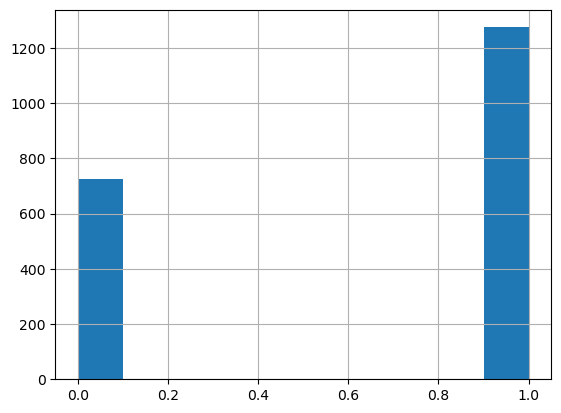

In [4]:
train['y'].hist()

In [5]:
# Выборка несбалансированная.

In [6]:
# перемешиваем данные
train = shuffle(train)
train.head()

,text,y
809,i 'm very pleased with my zx so here 's a quic...,1
812,"i love how small the thing is , and the blue g...",1
406,"it 's overkill for simple snapshots , unless y...",1
177,first 4 months it was in our bedroom and we di...,1
1569,i love this player .,1


In [7]:
# Для ручной раметки выделем только 10% датасета
unlabel_train, label_train = train_test_split(train, train_size=0.1, random_state=42)

In [8]:
label_train.head()

,text,y
4,i was using the cheapie pail ... and it worked...,1
1022,"remote buttons are small and closely spaced , ...",0
442,"for example , i tried playing my new "" pirates...",0
589,"the other day when i was listening to a song ,...",0
423,creative did an awesome job with the design .,1


In [9]:
# удалим разметку для unlabel_train
del unlabel_train['y']
unlabel_train.head()

,text
1705,regarding pc software support nokia suite does...
1432,"sure , it 's a little bigger than the ipod , b..."
1402,the software has n't been a hassle for me at a...
1380,"unfortunately , after loading 280 + songs , al..."
1505,"if you experience problems with installation ,..."


In [10]:
# Определение фукции для обучения модели лог. регрессии на размеченных данных
def train_model(label_train):
    # Векторизация текстовых данных TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(label_train['text'])
    y = label_train['y']
    
    # Обучение модели лог. регрессии на размечанных данных
    model = LogisticRegression()
    model.fit(X, y)
    
    return model, vectorizer

In [11]:
# обучение модели
model, vectorizer = train_model(label_train)

In [12]:
# Использование исходной модели для прогнозирования настроения неразмеченных данных
X_unlabeled = vectorizer.transform(unlabel_train['text'])
y_unlabeled_predicted = model.predict(X_unlabeled)

In [13]:
# Вычеслим неопределенности или энтропии предсказаний
y_unlabeled_proba = model.predict_proba(X_unlabeled)
uncertainty = -(y_unlabeled_proba * np.log2(y_unlabeled_proba)).sum(axis=1)

In [14]:
# Выбор 100 наиболее неопределенных точек данных для маркировки человеком
labeled_train_new = unlabel_train.iloc[uncertainty.argsort()[:100]]
unlabeled_train_new = unlabel_train.iloc[uncertainty.argsort()[100:]]

In [15]:
# label_train_new, label_train_new['y'] = unlabel_train.iloc[uncertainty.argsort()[100:]], uncertainty[100:]
# ручной разметки данных сохраним в csv
labeled_train_new.to_csv('data/unlabeled/label_train_new.csv', index=False)
unlabeled_train_new.to_csv('data/unlabeled/unlabeled_train_new.csv', index=False)

### После ручной разметки в Label Studio заргуризим датасет

In [16]:
# после ручной разметки в Label Studio заргуризим датасет
unlabeled_train_new = pd.read_csv('data/unlabeled/unlabeled_train_new_ls.csv')
unlabeled_train_new = unlabeled_train_new[['text', 'sentiment']]
unlabeled_train_new

,text,sentiment
0,creative has put a lot of effort into making t...,pos
1,navigation is easy and i found that syncing fi...,pos
2,the g3 looks like a work of art !,pos
3,"all and all , i am extremely pleased with this...",pos
4,it is easy enough to use for a beginner like m...,pos
...,...,...
95,very cool features ... great camera with zoom ...,pos
96,the price / performance looked just right .,pos
97,this phone has a very cool and useful feature ...,pos
98,i didnt have any installation problems ; and t...,pos


In [17]:
unlabeled_train_new['sentiment'] = unlabeled_train_new['sentiment'].replace({'pos': 1, 'neg': 0})

In [18]:
unlabeled_train_new = unlabeled_train_new.rename(columns={'sentiment': 'y'})
unlabeled_train_new.head()

,text,y
0,creative has put a lot of effort into making t...,1
1,navigation is easy and i found that syncing fi...,1
2,the g3 looks like a work of art !,1
3,"all and all , i am extremely pleased with this...",1
4,it is easy enough to use for a beginner like m...,1


In [19]:
# Разметка новых точек данны и добавление их к рамеченному множеству
label_train = pd.concat([label_train, unlabeled_train_new])
label_train.head()

,text,y
4,i was using the cheapie pail ... and it worked...,1
1022,"remote buttons are small and closely spaced , ...",0
442,"for example , i tried playing my new "" pirates...",0
589,"the other day when i was listening to a song ,...",0
423,creative did an awesome job with the design .,1


In [20]:
label_train.shape

(1900, 2)

In [21]:
# переочучаем модель на расширенном маркированном множестве
model, vectorizer = train_model(label_train)

In [22]:
X_test = pd.read_csv('data/products_sentiment_test.tsv', sep='\t', index_col='Id')
X_test.head()

,text
Id,
0,"so , why the small digital elph , rather than ..."
1,3/4 way through the first disk we played on it...
2,better for the zen micro is outlook compatibil...
3,6 . play gameboy color games on it with goboy .
4,"likewise , i 've heard norton 2004 professiona..."


In [23]:
y_test = pd.read_csv('data/products_sentiment_sample_submission.csv', index_col='Id')
y_test.head()

,y
Id,
0,0
1,1
2,0
3,1
4,0


In [24]:
X_test = vectorizer.transform(X_test['text'])
y_test_predicted = model.predict(X_test)
f1 = f1_score(y_test['y'], y_test_predicted)
f1

0.5996908809891808

Для лучшего рещультата, можно попробовать след. улучшения:
- Выполнить балансировку (так, как выборка несбалансированная)
- Удалить стоп слова из комемнтариев, тем самым убрать шум для луч. результата. 
- и др....